# EPEX price forecast 

This notebook explores the EPEX time series to build a model forecasting the UK spot power price, half hourly, for the next day.

Our goal is to build two competing models and compare their performance, exploiting the following data:

1.	apx_20140101-2020-09-31.csv : this is the target variable that we would like you to forecast
2.	weather_lj_20160101-2020-09-31.csv : this is some weather data that may be useful for building your model
3.	bmrs_raw_data_interview_2014-12-31_2020-10-01.parquet : this is some further data around the UK power market that may be useful for building your model


*	Please explain your reasoning for selecting the model type that you have chosen: I train a simple XGBoost on the previous week's worth of explanatory variables to predict the spot price 48 hours ahead. XGBoost is known to deliver very good results and is simple to train - perfect for this exercise. In order to predict time series with XGBoost, we needd to transform the time series probelem into a supervised learning problem. I choose here to train and XGBoost instead of a more traditional ARIMA or ARIMAX in order to focus on precitions accuracy. While XGBoost is more agnostic about the underlying drivers of the time series relative to ARIMA, though can be very accurate in predicting.
*	How do you measure the performance of this forecast? Is this performance adequate? What could you do to improve the performance of your model? I'll measure performance using the root mean square error (RMSE). This metric is useful to assess average deviation error between the prediction and the actual observation. RMSE is unit dependent. So to confirm model accuracy is adequate, we need to compare the RMSE to the magnitude of the target variable
*	What steps would be required to deploy and productionise this model? The production requirement of the model require every day at 7am to have the next 48 half hourly spot price prediction. We thus need to automate data collection every day to produce estimates at 6.30am each day. This can be easily be done leveraging AWS infrastructre. This requires 3 things: 1/ a database that is updated daily with new data flow, 2/ a storage facility where to save the model predictions and 3/ a container image that runs the data from 1/ passed the trainedd model adn saves the outputs in 2/. The task needs to be programmed to occur daily at 6.30am

The notebook is organised as follows:

1. EDA and cleaning
1. Feature engineering
1. Train/test split
1. Model building
1. Results / discussion

In [75]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.stats import skew, kurtosis, shapiro
from pyarrow.parquet import ParquetFile
import pyarrow.parquet
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb

from math import sqrt


In [2]:
def duplicate_index(df):
    dup =df.index.duplicated(keep=False)
    print(f"there are a total of {sum(dup)} duplicated indices")
    return dup

def missing_timestamp(df):
    idx = pd.date_range(df.index.min(), df.index.max(), freq="30min")
    print(f"There are {abs(len(idx)-len(df))} missing timesteps")
    return idx

## 1. EDA and cleaning

### 1.1. Import data

#### 1.1.1. EPEX (power price)

In [3]:
# load epex dataset
epex = pd.read_csv('apx_20140101-2020-09-31.csv')

In [4]:
# inspect head
epex.head()

utc  value
0  2014-01-01 00:00:00+0000   34.1
1  2014-01-01 00:30:00+0000   34.1
2  2014-01-01 01:00:00+0000   34.1
3  2014-01-01 01:30:00+0000   34.1
4  2014-01-01 02:00:00+0000   34.0

In [5]:
epex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118318 entries, 0 to 118317
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   utc     118318 non-null  object 
 1   value   118318 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


The 'utc' columnn is recognised as an object. Let's parse it as a timestamp and set it to the index of the time series

In [6]:
# transform to datetime
epex["utc"] = pd.to_datetime(epex["utc"], utc=True, infer_datetime_format=True)
# ensure seconds and microseconsd are 0
epex["utc"] = epex["utc"].map(lambda x: x.replace(microsecond=0))
epex.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118318 entries, 0 to 118317
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   utc     118318 non-null  datetime64[ns, UTC]
 1   value   118318 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 1.8 MB


In [7]:
# Find if there are NaNs in the energy price
print('There are {} missing values or NaNs in the epex data.'
      .format(epex.isnull().values.sum()))

# Find if there are duplicated rows
dup = epex.duplicated(keep='first').sum()
print('There are {} duplicate rows in epex data based on all columns.'
      .format(dup))


There are 0 missing values or NaNs in the epex data.
There are 0 duplicate rows in epex data based on all columns.


In [8]:
# set index to timestamp
epex.set_index('utc', inplace = True)

In [9]:
# name column as price
epex.columns = ['price']

In [10]:
# check if duplicates in index
dup = duplicate_index(epex)
epex[dup]

there are a total of 24 duplicated indices


price
utc                             
2014-10-26 01:00:00+00:00  32.91
2014-10-26 01:30:00+00:00  32.91
2014-10-26 01:00:00+00:00  31.91
2014-10-26 01:30:00+00:00  31.91
2015-10-25 01:00:00+00:00  34.60
2015-10-25 01:30:00+00:00  34.60
2015-10-25 01:00:00+00:00  33.18
2015-10-25 01:30:00+00:00  33.18
2016-10-30 01:00:00+00:00  39.70
2016-10-30 01:30:00+00:00  39.70
2016-10-30 01:00:00+00:00  42.95
2016-10-30 01:30:00+00:00  42.95
2017-10-29 01:00:00+00:00  21.80
2017-10-29 01:30:00+00:00  21.80
2017-10-29 01:00:00+00:00  23.48
2017-10-29 01:30:00+00:00  23.48
2018-10-28 01:00:00+00:00  52.59
2018-10-28 01:30:00+00:00  52.59
2018-10-28 01:00:00+00:00  52.52
2018-10-28 01:30:00+00:00  52.52
2019-10-27 01:00:00+00:00  22.26
2019-10-27 01:30:00+00:00  22.26
2019-10-27 01:00:00+00:00  22.88
2019-10-27 01:30:00+00:00  22.88

There seems to be an error in the entry of values. For the dates of 2014-10-26 01:00 and 01:30 we have a two entries: one where each is 32.9 and another where both are 31.91. There has been a ro mismatch. For simplicity, let's just keep the first occurence of the each value.

We also need to check the time series is complete: there needs to be a value for each timestep, half hourly, in between the date range. Where a timestep is missing, let's interpolate its value linearly.


In [11]:
# remove duplicate indices
epex = epex[~epex.index.duplicated(keep='first')]

In [12]:
# check if gaps in the timesteps
idx = missing_timestamp(epex)

There are 14 missing timesteps


In [13]:
# linear interpolation
epex = epex.reindex(idx)
epex = epex.interpolate()

Let's plot the whole time series

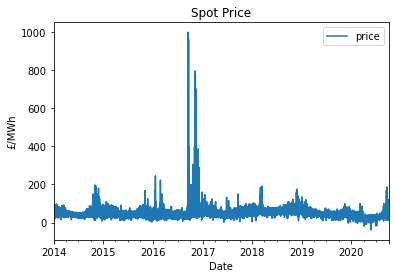

In [14]:
epex.plot(title="Spot Price")
plt.ylabel("£/MWh")
plt.xlabel("Date")
plt.show()

#### 1.1.2. Weather data

In [15]:
# load weather data
weather = pd.read_csv('weather_lj_20160101-2020-09-31.csv', index_col = 0)


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304185 entries, 1 to 2304185
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   utc     object 
 1   name    object 
 2   value   float64
 3   lat     float64
 4   lon     float64
dtypes: float64(3), object(2)
memory usage: 105.5+ MB


In [17]:
# inspect head
weather.head()

utc               name        value      lat     lon
1  2016-03-28 01:00:00      precipitation     2.246900  51.0063 -2.6428
2  2016-03-28 01:00:00           pressure  1103.227900  51.0063 -2.6428
3  2016-03-28 01:00:00  relative humidity    94.819180  51.0063 -2.6428
4  2016-03-28 01:00:00    solar radiation     0.000000  51.0063 -2.6428
5  2016-03-28 01:00:00        temperature    10.223395  51.0063 -2.6428

We note that the weather data is in long format. The column 'name' contains the variable names. We'll need to transform this to wide format. There is an additional complication though. Each variable in the column 'name' is reported for different locations (lat/lon combinations) at the same timestep.

Let's determine the number of unique locations and number of variables

In [18]:
# convert utc to datetime
weather["utc"] = pd.to_datetime(weather["utc"], utc=True, infer_datetime_format=True)
# generate unique location variable 
weather['loc'] = weather['lat']+weather['lon']
uniq_loc = (weather['loc']).unique()
uniq_var = weather['name'].unique()
print(f'There are {len(uniq_loc)} unique locations')
print(f'There are {len(uniq_var)} unique variables')

There are 13 unique locations
There are 7 unique variables


We need to create 7*13 new variables, one per each location. First let's check duplicates


In [19]:
# duplicate rows
dup = weather.duplicated(subset = ['utc', 'name', 'loc'], keep =False).sum()

print('There are {} duplicate rows in weather dataset.'
      .format(dup))

There are 728 duplicate rows in weather dataset.


In [20]:
# drop duplicate rows
weather.drop_duplicates(subset=['utc', 'name', 'loc'], inplace=True)

In [21]:
# generate variables specific to each location
maped = {uniq_loc[i]:str(i) for i in range(len(uniq_loc))}

In [22]:
# create unique var/loc combination
weather['loc'] = weather['loc'].map(maped)
weather['var'] =weather['name'] +weather['loc'] 


In [23]:
# reshape from long to wide
weather_clean = pd.pivot(weather, index='utc',columns='var', values='value')
# remove multi-index
weather_clean.columns = list(weather_clean.columns)

In [24]:
weather_clean.head()

precipitation0  precipitation1  precipitation10  \
utc                                                                          
2016-03-28 01:00:00+00:00        2.246900        1.685175         0.000000   
2016-03-28 02:00:00+00:00        1.235795        1.909865         0.112345   
2016-03-28 03:00:00+00:00        1.235795        2.134555         0.000000   
2016-03-28 04:00:00+00:00        1.123450        2.134555         0.000000   
2016-03-28 05:00:00+00:00        1.011105        2.134555         0.000000   

                           precipitation11  precipitation12  precipitation2  \
utc                                                                           
2016-03-28 01:00:00+00:00         0.112345              0.0        2.808625   
2016-03-28 02:00:00+00:00         0.000000              0.0        1.797520   
2016-03-28 03:00:00+00:00         0.000000              0.0        1.797520   
2016-03-28 04:00:00+00:00         0.000000              0.0        1.685175   
2016-03-28 05:00:00+00:00         0.000000              0.0        1.460485   

                           precipitation3  precipitation4  precipitation5  \
utc                                                                         
2016-03-28 01:00:00+00:00        1.685175        0.561725        0.674070   
2016-03-28 02:00:00+00:00        1.909865        1.123450        1.685175   
2016-03-28 03:00:00+00:00        2.134555        1.797520        2.808625   
2016-03-28 04:00:00+00:00        2.134555        1.797520        2.808625   
2016-03-28 05:00:00+00:00        2.134555        1.685175        2.808625   

                           precipitation6  ...  wind speed11  wind speed12  \
utc                                        ...                               
2016-03-28 01:00:00+00:00        0.000000  ...       5.61725       8.98760   
2016-03-28 02:00:00+00:00        0.561725  ...       5.61725       8.98760   
2016-03-28 03:00:00+00:00        2.022210  ...       4.49380       7.86415   
2016-03-28 04:00:00+00:00        3.033315  ...       4.49380       7.86415   
2016-03-28 05:00:00+00:00        3.482695  ...       3.37035       7.86415   

                           wind speed2  wind speed3  wind speed4  wind speed5  \
utc                                                                             
2016-03-28 01:00:00+00:00     16.85175     16.85175     15.72830      8.98760   
2016-03-28 02:00:00+00:00     15.72830     17.97520     17.97520     10.11105   
2016-03-28 03:00:00+00:00     14.60485     20.22210     20.22210     13.48140   
2016-03-28 04:00:00+00:00     13.48140     21.34555     22.46900     14.60485   
2016-03-28 05:00:00+00:00     13.48140     22.46900     23.59245     14.60485   

                           wind speed6  wind speed7  wind speed8  wind speed9  
utc                                                                            
2016-03-28 01:00:00+00:00      6.74070      6.74070      6.74070     10.11105  
2016-03-28 02:00:00+00:00      7.86415      5.61725      5.61725      8.98760  
2016-03-28 03:00:00+00:00      8.98760      4.49380      4.49380      6.74070  
2016-03-28 04:00:00+00:00     10.11105      4.49380      4.49380      5.61725  
2016-03-28 05:00:00+00:00     11.23450      5.61725      5.61725      6.74070  

[5 rows x 91 columns]

In [25]:
# check if duplicates in index
dup = duplicate_index(weather_clean)

there are a total of 0 duplicated indices


In [26]:
# check if gaps in the timesteps
idx = missing_timestamp(weather_clean)

There are 53786 missing timesteps


In [27]:
weather_clean['precipitation0'].plot(title="Precipitation at loc 0")
plt.ylabel("precipitation")
plt.xlabel("Date")
plt.show()

In [28]:
weather_clean['wind speed6'].plot(title="Wind speed at loc 6")
plt.ylabel("Wind speed")
plt.xlabel("Date")
plt.show()

The weather data has many missing entries:
* timestep is hourly - instead of half hourly as desired
* the period December-March is missing every year

Let's interpolate linearly for simplicity the missinga data, to remove gaps from the series

In [29]:
# define new index, filling half hour gaps
weather_clean = weather_clean.reindex(idx)
# interpolate linearly
weather_clean = weather_clean.interpolate()



### 1.1.3. Additional data

In [30]:
# load additional data
additional = pd.read_parquet('bmrs_raw_data_interview_2014-12-31_2020-10-01.parquet')


In [31]:
additional.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100849 entries, 2014-12-31 00:00:00+00:00 to 2020-10-01 00:00:00+00:00
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   DANF                             100849 non-null  float64
 1   DATF                             100849 non-null  float64
 2   INDO                             100847 non-null  float64
 3   ITSDO                            100847 non-null  float64
 4   DAIG                             100081 non-null  float64
 5   Consumption                      100010 non-null  float64
 6   DAM                              100849 non-null  float64
 7   fuelTypeGeneration               25680 non-null   float64
 8   initialForecastSpnGeneration     13560 non-null   float64
 9   latestForecastSpnGeneration      13560 non-null   float64
 10  Biomass                          100849 non-null  float64
 11  Generation         

In [32]:
# inspect head
additional.head()

DANF     DATF     INDO    ITSDO     DAIG  \
utc                                                                      
2014-12-31 00:00:00+00:00  30400.0  31504.0  29828.0  30989.0  31782.0   
2014-12-31 00:30:00+00:00  30500.0  31971.0  29937.0  31403.0  32046.0   
2014-12-31 01:00:00+00:00  29628.0  31672.0  29470.0  31487.0  31572.0   
2014-12-31 01:30:00+00:00  28875.0  30775.0  28545.0  30577.0  31024.0   
2014-12-31 02:00:00+00:00  28180.0  30239.0  27901.0  30003.0  30478.0   

                           Consumption      DAM  fuelTypeGeneration  \
utc                                                                   
2014-12-31 00:00:00+00:00      30949.0  28612.0                 NaN   
2014-12-31 00:30:00+00:00      31207.0  28393.0                 NaN   
2014-12-31 01:00:00+00:00      31017.0  28663.0                 NaN   
2014-12-31 01:30:00+00:00      30431.0  29573.0                 NaN   
2014-12-31 02:00:00+00:00      30426.0  30437.0                 NaN   

                           initialForecastSpnGeneration  \
utc                                                       
2014-12-31 00:00:00+00:00                        2437.0   
2014-12-31 00:30:00+00:00                           NaN   
2014-12-31 01:00:00+00:00                        2525.0   
2014-12-31 01:30:00+00:00                           NaN   
2014-12-31 02:00:00+00:00                        2632.0   

                           latestForecastSpnGeneration  ...     Load  \
utc                                                     ...            
2014-12-31 00:00:00+00:00                       3563.0  ...  37863.0   
2014-12-31 00:30:00+00:00                          NaN  ...  37863.0   
2014-12-31 01:00:00+00:00                       3621.0  ...  37863.0   
2014-12-31 01:30:00+00:00                          NaN  ...  37863.0   
2014-12-31 02:00:00+00:00                       3681.0  ...  37863.0   

                           Wind Onshore  Wind Offshore  AC Link  Fossil Gas  \
utc                                                                           
2014-12-31 00:00:00+00:00        9425.0        12474.0      0.0     84651.0   
2014-12-31 00:30:00+00:00        9425.0        12474.0      0.0     84651.0   
2014-12-31 01:00:00+00:00        9425.0        12474.0      0.0     84651.0   
2014-12-31 01:30:00+00:00        9425.0        12474.0      0.0     84651.0   
2014-12-31 02:00:00+00:00        9425.0        12474.0      0.0     84651.0   

                           Fossil Oil   Nuclear  Other  Transformer  \
utc                                                                   
2014-12-31 00:00:00+00:00     24962.0  143612.0  770.0          0.0   
2014-12-31 00:30:00+00:00     24962.0  143612.0  770.0          0.0   
2014-12-31 01:00:00+00:00     24962.0  143612.0  770.0          0.0   
2014-12-31 01:30:00+00:00     24962.0  143612.0  770.0          0.0   
2014-12-31 02:00:00+00:00     24962.0  143612.0  770.0          0.0   

                           Hydro Water Reservoir  
utc                                               
2014-12-31 00:00:00+00:00                    0.0  
2014-12-31 00:30:00+00:00                    0.0  
2014-12-31 01:00:00+00:00                    0.0  
2014-12-31 01:30:00+00:00                    0.0  
2014-12-31 02:00:00+00:00                    0.0  

[5 rows x 24 columns]

In [33]:
# inspect metadata
schema = pyarrow.parquet.read_schema('bmrs_raw_data_interview_2014-12-31_2020-10-01.parquet', memory_map=True)
schema

DANF: double
  -- field metadata --
  PARQUET:field_id: '1'
DATF: double
  -- field metadata --
  PARQUET:field_id: '2'
INDO: double
  -- field metadata --
  PARQUET:field_id: '3'
ITSDO: double
  -- field metadata --
  PARQUET:field_id: '4'
DAIG: double
  -- field metadata --
  PARQUET:field_id: '5'
Consumption: double
  -- field metadata --
  PARQUET:field_id: '6'
DAM: double
  -- field metadata --
  PARQUET:field_id: '7'
fuelTypeGeneration: double
  -- field metadata --
  PARQUET:field_id: '8'
initialForecastSpnGeneration: double
  -- field metadata --
  PARQUET:field_id: '9'
latestForecastSpnGeneration: double
  -- field metadata --
  PARQUET:field_id: '10'
Biomass: double
  -- field metadata --
  PARQUET:field_id: '11'
Generation: double
  -- field metadata --
  PARQUET:field_id: '12'
Fossil Hard coal: double
  -- field metadata --
  PARQUET:field_id: '13'
Hydro Run-of-river and poundage: double
  -- field metadata --
  PARQUET:field_id: '14'
Load: double
  -- field metadata --
  P

In [34]:
# check if duplicates in index
dup = duplicate_index(additional)
additional[dup]

there are a total of 0 duplicated indices


Empty DataFrame
Columns: [DANF, DATF, INDO, ITSDO, DAIG, Consumption, DAM, fuelTypeGeneration, initialForecastSpnGeneration, latestForecastSpnGeneration, Biomass, Generation, Fossil Hard coal, Hydro Run-of-river and poundage, Load, Wind Onshore, Wind Offshore, AC Link, Fossil Gas, Fossil Oil, Nuclear, Other, Transformer, Hydro Water Reservoir]
Index: []

[0 rows x 24 columns]

In [35]:
# Find if there are NaNs in the energy price
print('There are {} missing values or NaNs in the epex data.'
      .format(additional.isnull().values.sum()))


There are 251358 missing values or NaNs in the epex data.


The additional dataset presents 24 addditional variables, provided half hourly. There are a lot of missing values. Let's also interpolate linearly for simplicity


In [36]:
additional = additional.interpolate()

## 1.2 Merge
Though each dataset has a different start and end date, let's use the epex dataset as reference. We'll then restrict the data set to the overlapping dates of all 3 datasets

In [37]:
# merge all 3 datasets
data = epex.join(weather_clean, how = 'left')
data = data.join(additional, how = 'left')

### 1.2.1 Inspect all variables

In [38]:
def plot_simple(df, colname):
    df[colname].plot(title=colname)
    plt.ylabel(colname)
    plt.xlabel("Date")
    plt.show()


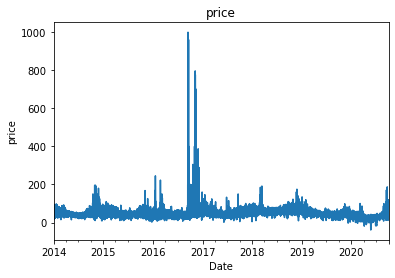

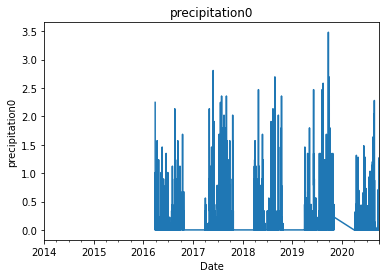

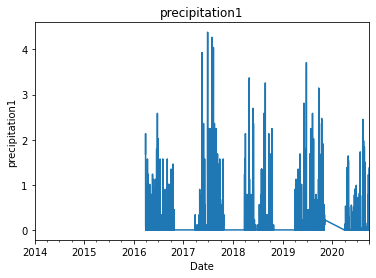

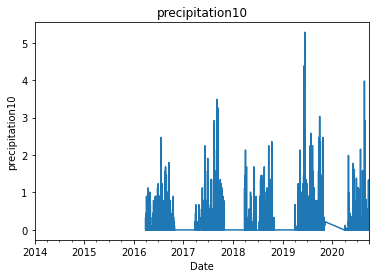

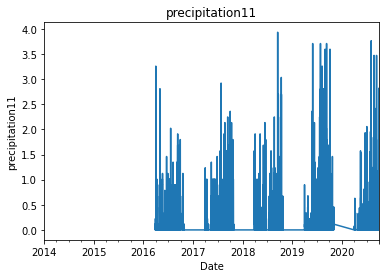

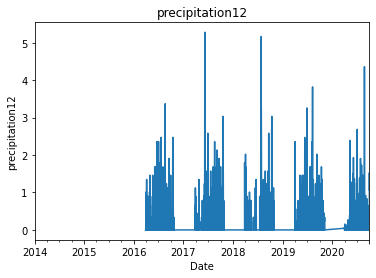

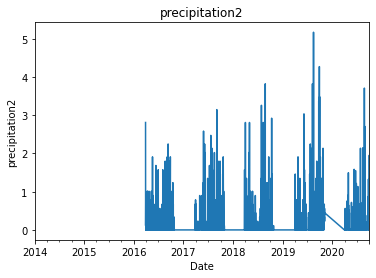

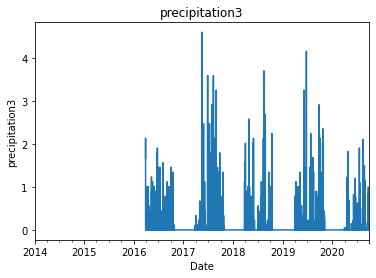

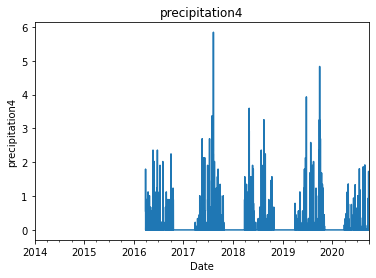

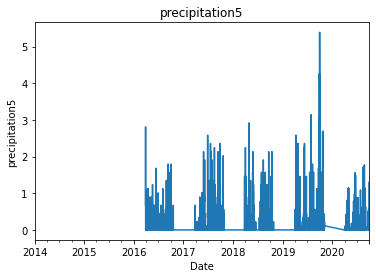

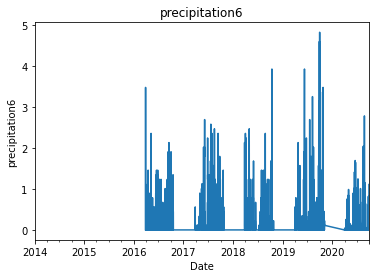

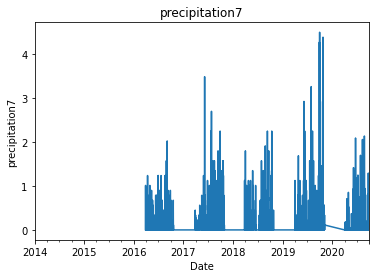

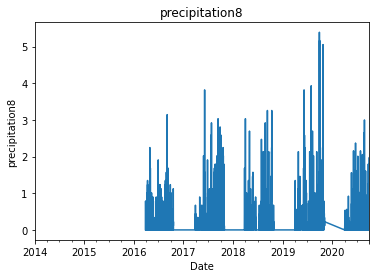

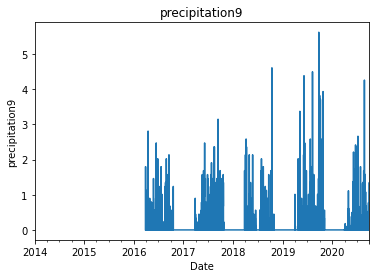

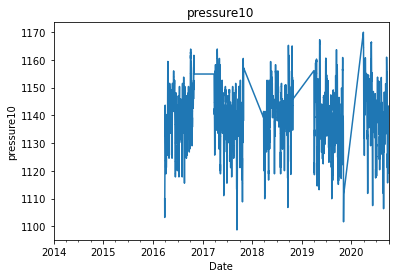

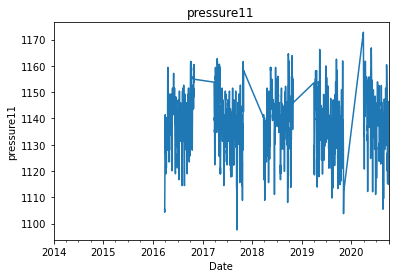

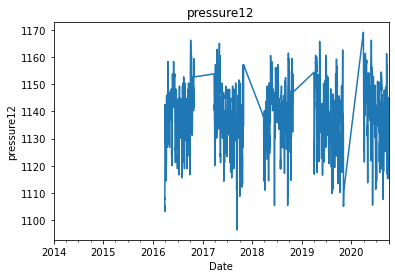

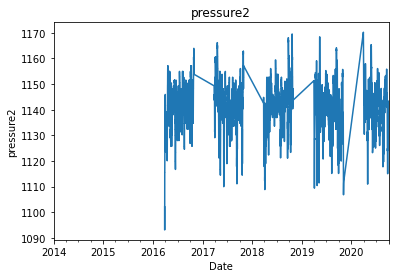

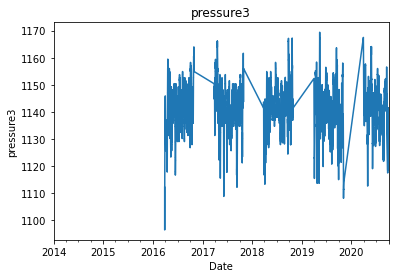

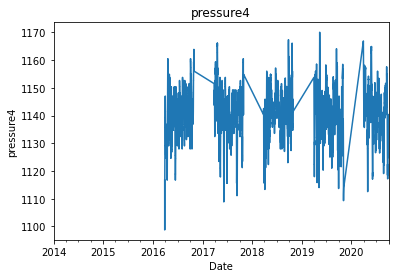

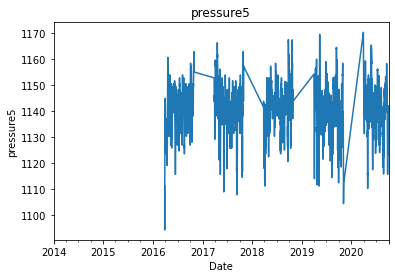

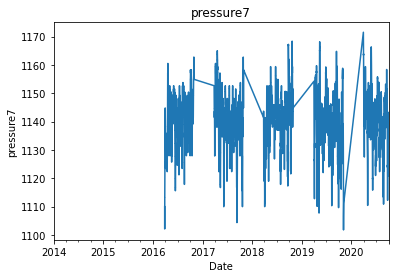

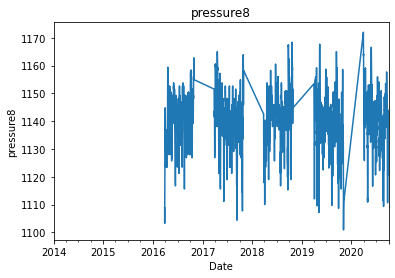

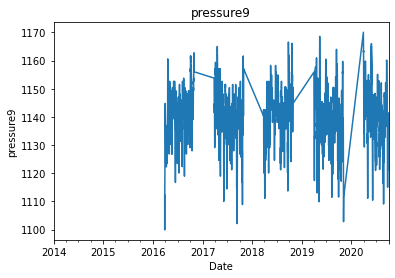

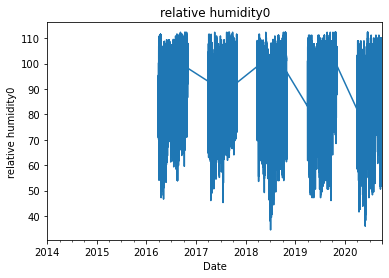

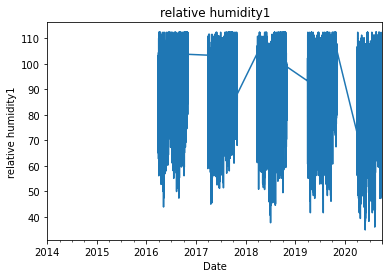

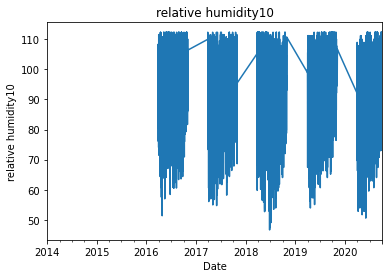

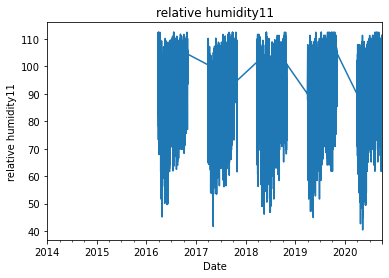

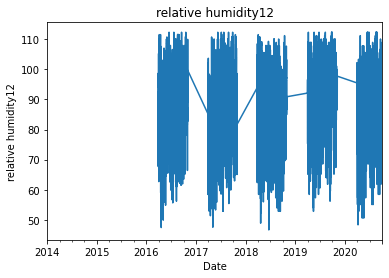

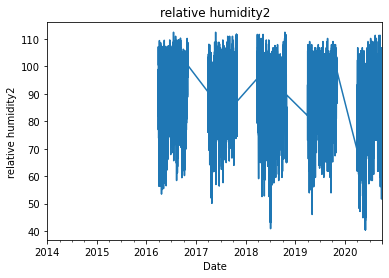

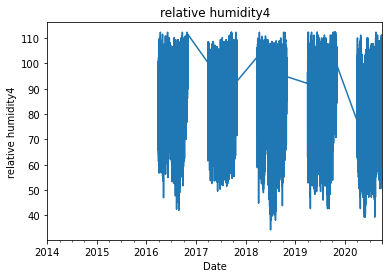

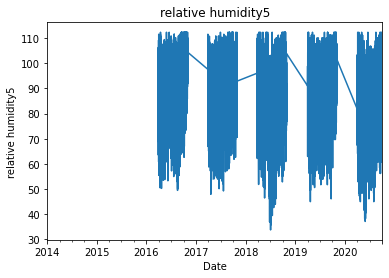

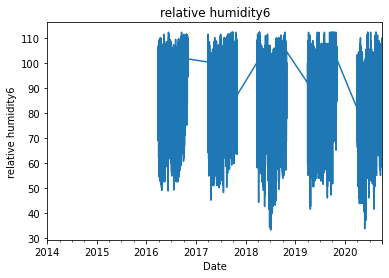

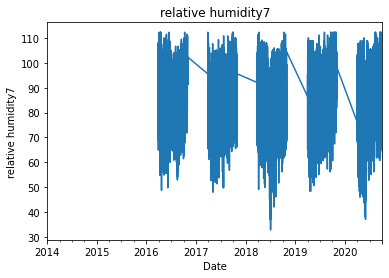

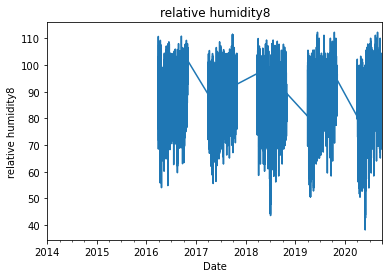

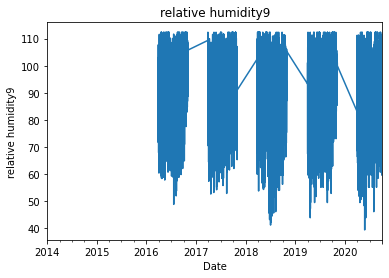

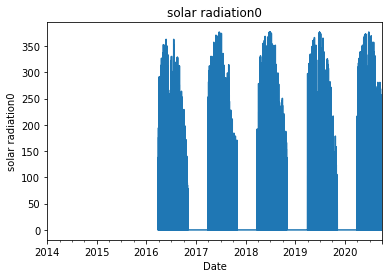

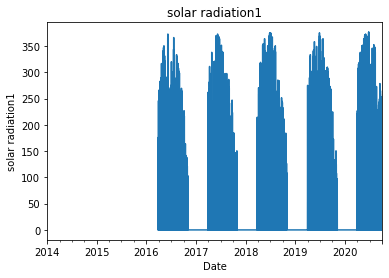

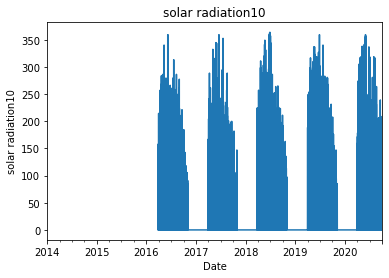

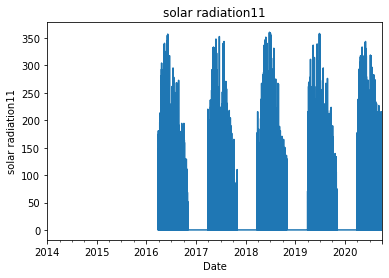

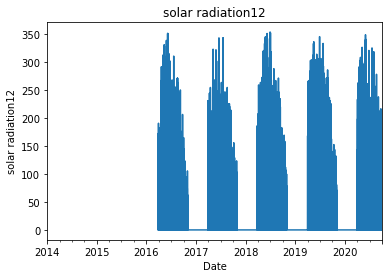

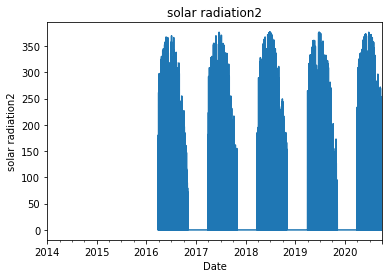

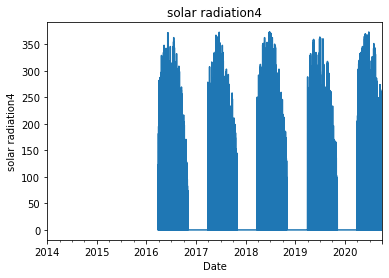

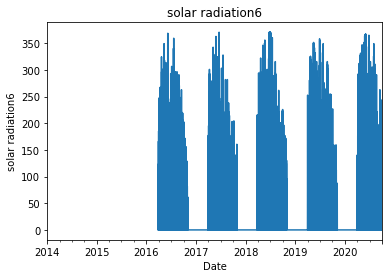

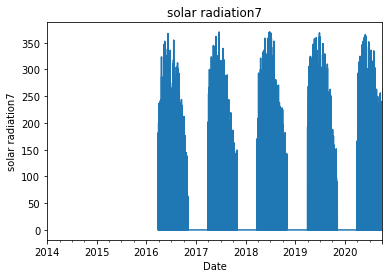

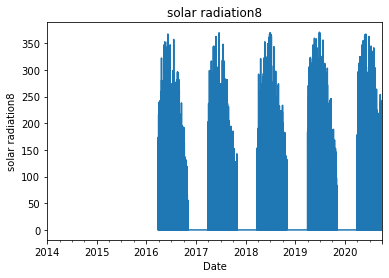

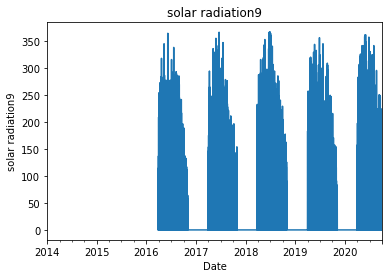

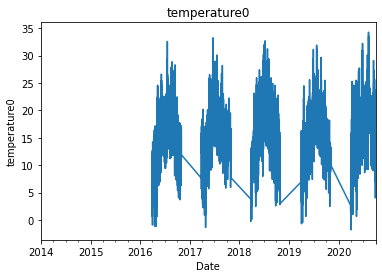

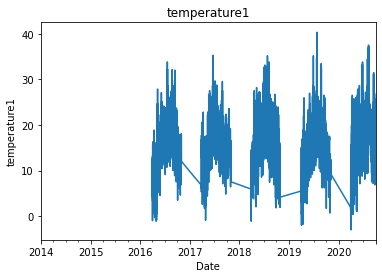

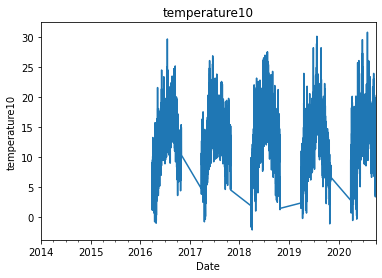

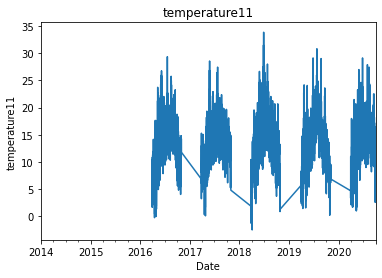

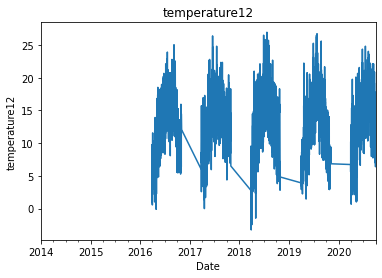

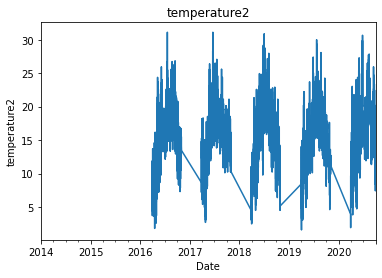

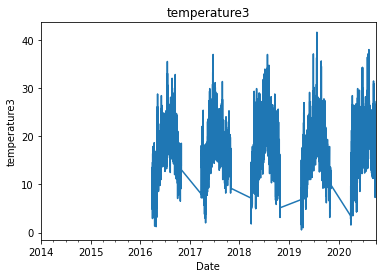

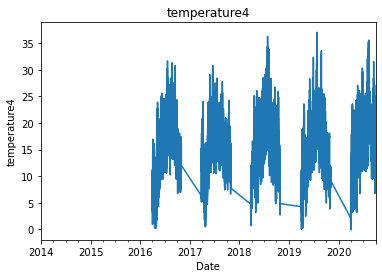

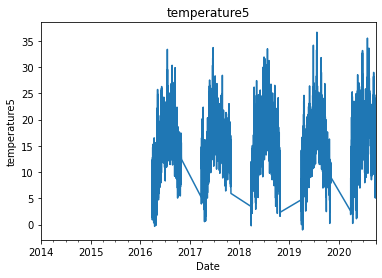

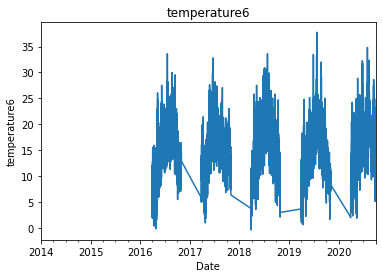

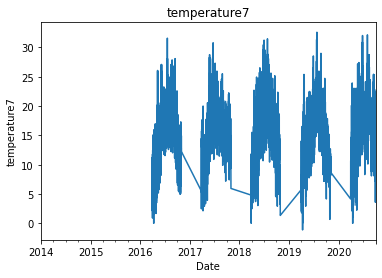

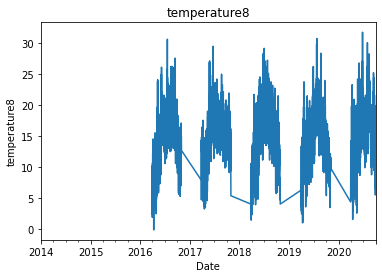

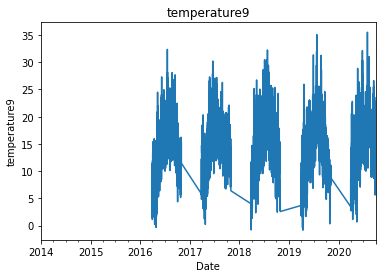

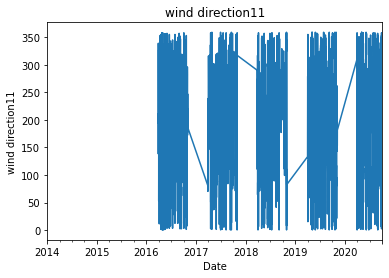

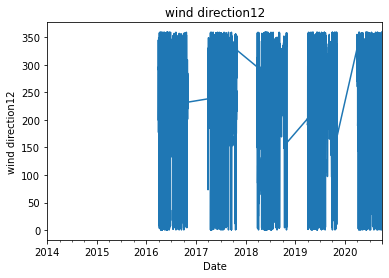

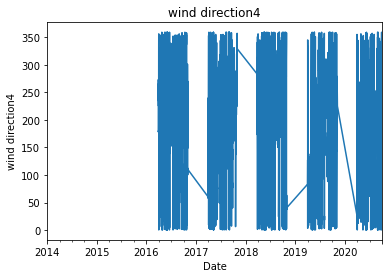

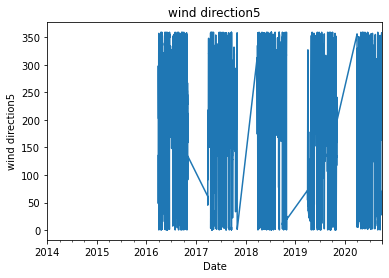

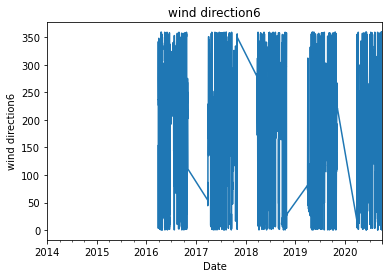

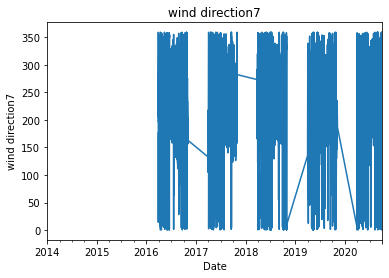

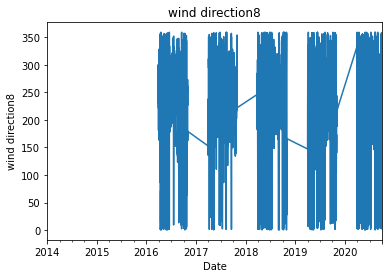

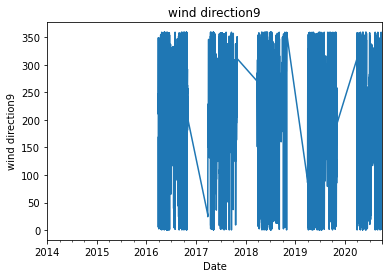

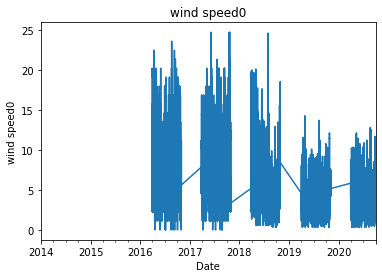

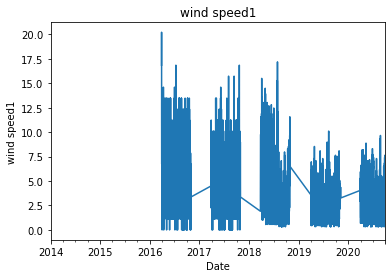

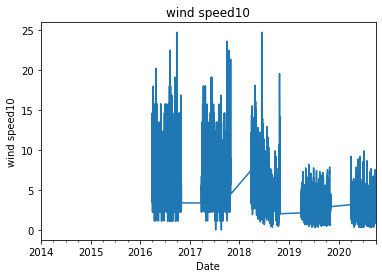

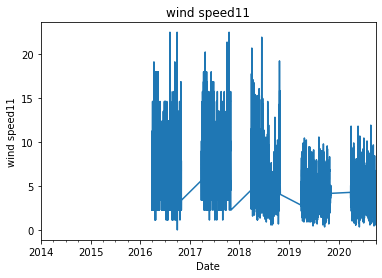

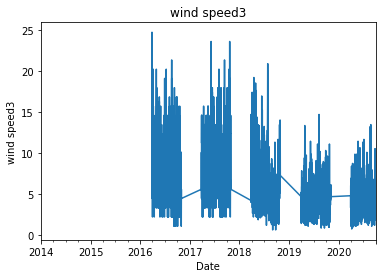

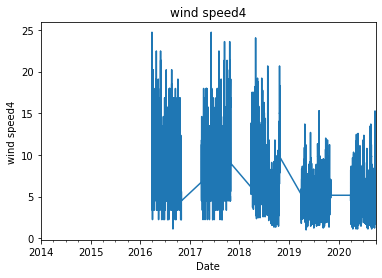

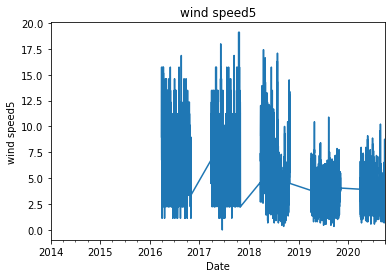

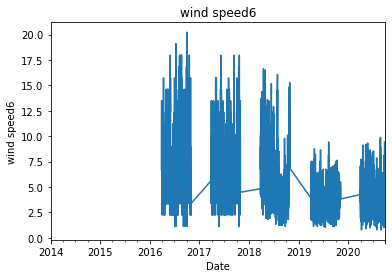

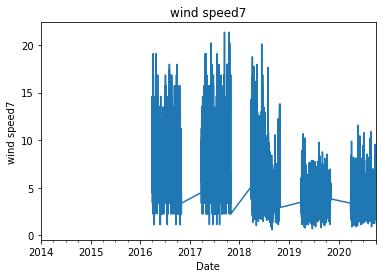

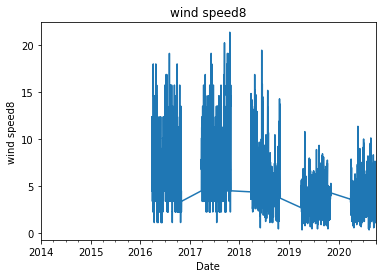

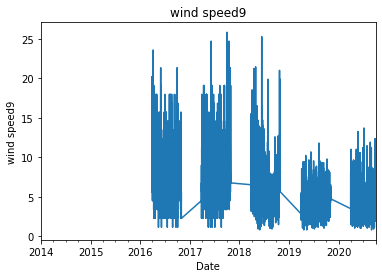

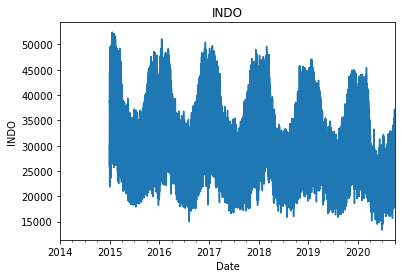

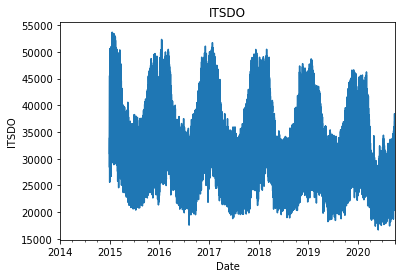

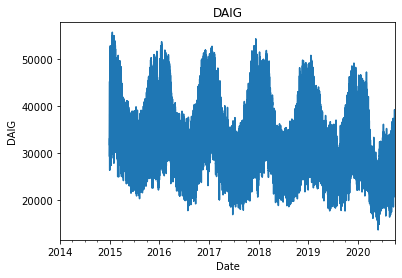

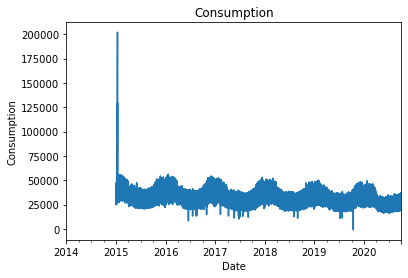

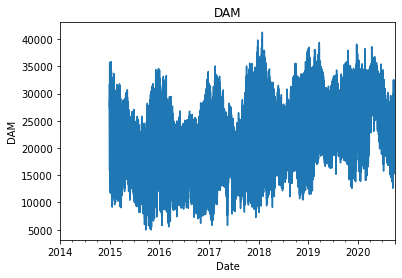

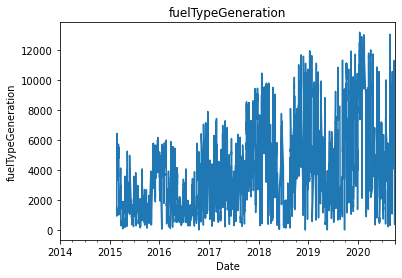

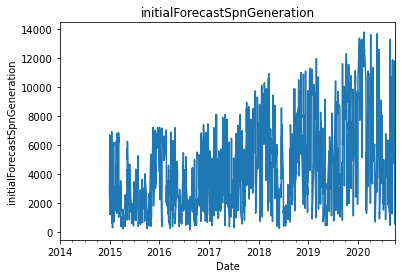

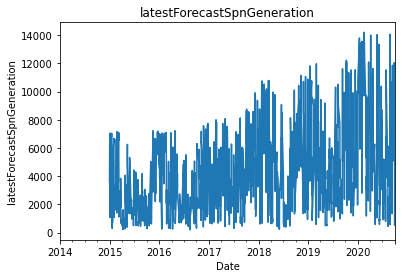

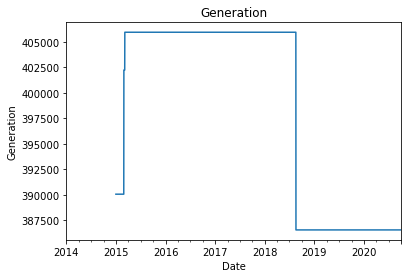

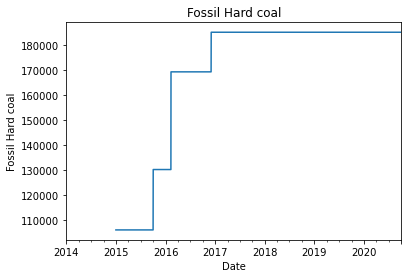

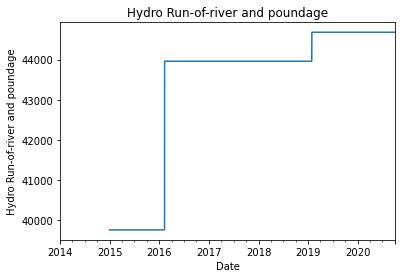

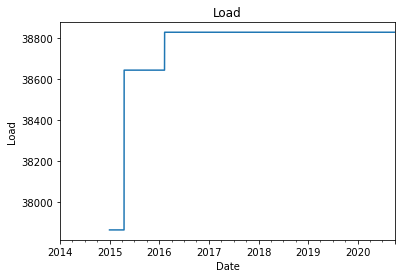

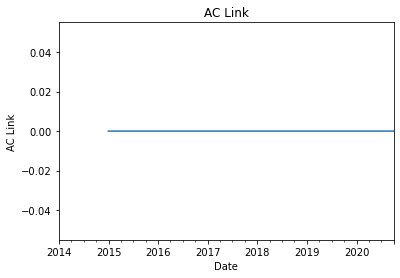

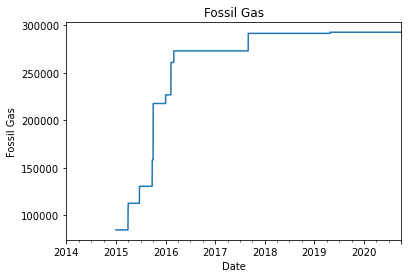

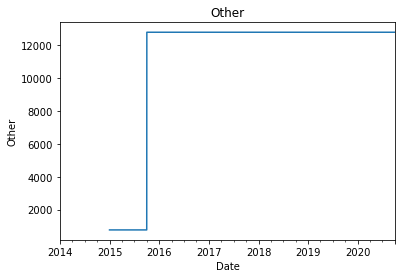

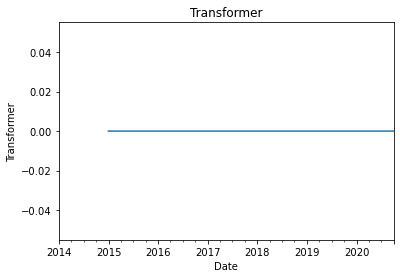

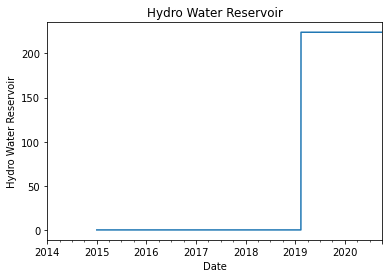

In [154]:
for var in data.columns:
    plot_simple(data, var)

Many of the additional variables have very little variation, carrying little to no uesful information for predicting power price half hourly. These variables are: biomass, generation, fossil hard coal, hydro run of river poundage, load, wind onshore, wind offshore, AC link (completely flatt, to be discarded), fossil gas, fossil oil (completely flat), nuclear (also flat), other (only 2 values), transformer (flat) and hydro water reservois (also 2 values).

All flat variables can just be removed.

The variable 'consumption' has some clear outliers in 2015. Let's remove them and interpolate linearly instead.

In [39]:
# remove outliers
data[data['Consumption']>60000]['Consumption']=np.nan
# interpolate NANs
data['Consumption'] = data['Consumption'].interpolate()



<ipython-input-39-10c66828ea4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['Consumption']>60000]['Consumption']=np.nan


### 1.2.3 Inspect target variable

In [40]:
# Histogram of spot price
ax = data['price'].plot.hist(bins=500)

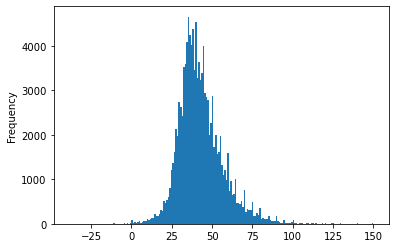

In [41]:
# Histogram of spot price without main ouliers
ax = data[data['price']<150]['price'].plot.hist(bins=200)

The distribution of the electricity spot price is close to a normal distribution. It also has some values in the negative. While this is surprising, in perios of low demand, this has been observed, especially during the spring 2020.

In [42]:
# Define a function to plot different types of time-series
def plot_var(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-42-f8efd93d2575>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_var(df=None, column=None, series=pd.Series([]),


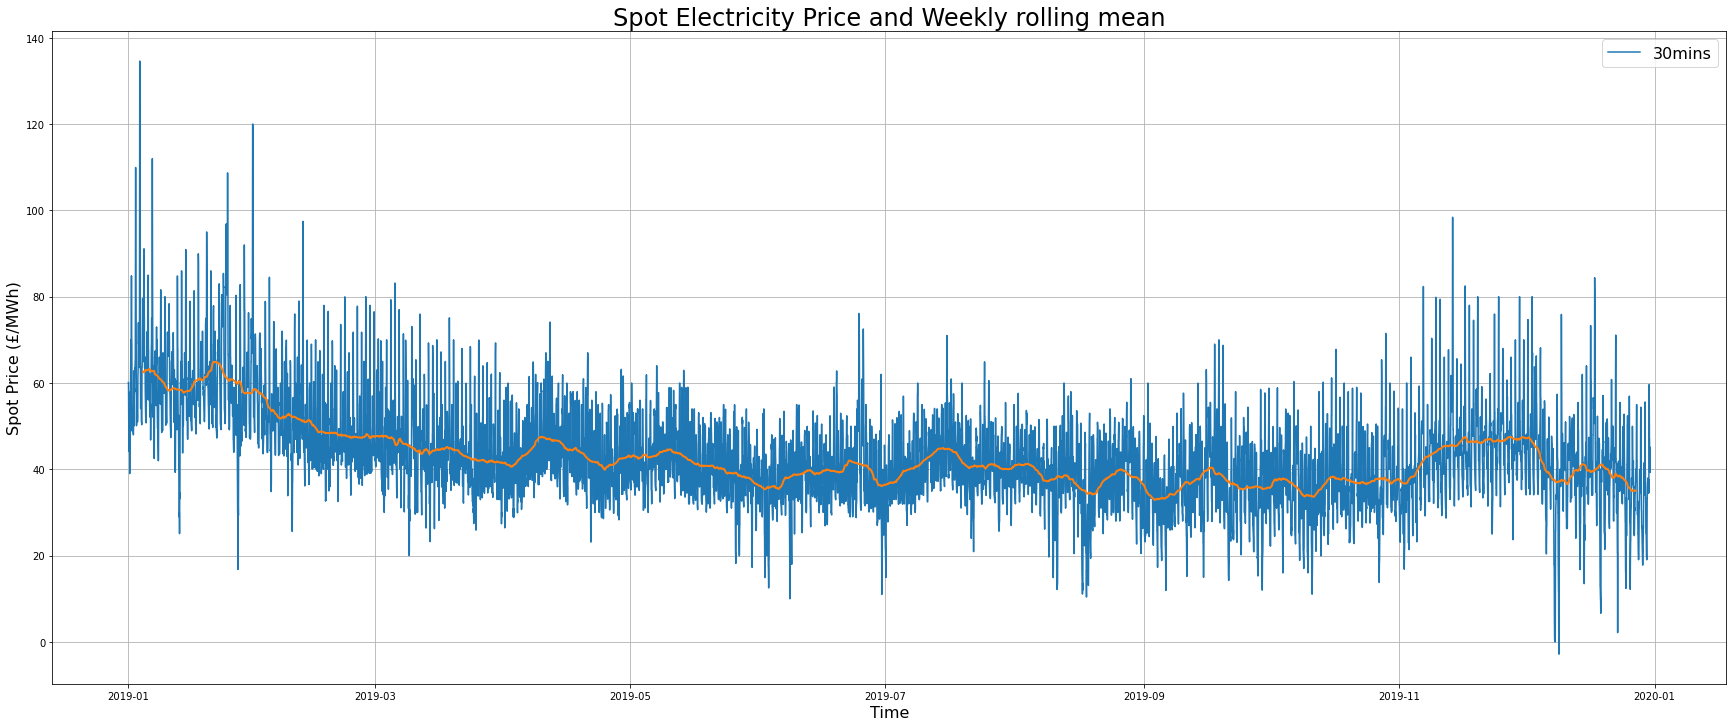

In [43]:
# Plot the hourly spot price and the weekly rolling mean for 2019
start = '2019-01-01'
end = '2019-12-30'
rolling = data.loc[start:end]['price'].rolling(48*7, center=True).mean()
ax = plot_var(data.loc[start:end], 'price', label='30mins', ylabel='Spot Price (£/MWh)',
                 title='Spot Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

In [44]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series
daily_price = data['price'].asfreq('M')
ax = plot_var(series = daily_price.loc[start:end], ylabel='Spot Price (£/MWh)',
                 title='Spot electricity price (Monthly frequency) and 1-year lagged price')
shifted = data['price'].asfreq('M').shift(12)
ax.plot(shifted.loc[start:end], label='Monthly')
ax.legend(['Price', '1-year Lagged Actual Price'])
plt.show()

The figure shows the monthly price and the year lag. A small seasonal pattern can be detected as the blue and orange line appear to be correlated. Monthly features should be considered

### 1.3 Time Series analysis


### 1.3.1 Stationarity
A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

The Augmented Dickey-Fuller (ADF) test determines how strongly a time series is defined by a trend.
- **Null hypthesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternative** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [45]:
y = data['price']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -15.204735
p-value: 0.000000
#Lags used: 70
Critical Value (1%): -3.430405
Critical Value (5%): -2.861564
Critical Value (10%): -2.566783


The ADF statistic (-15.20) is less than the critical value at 1% (-3.43) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

### 1.3.2 Autocorrelation

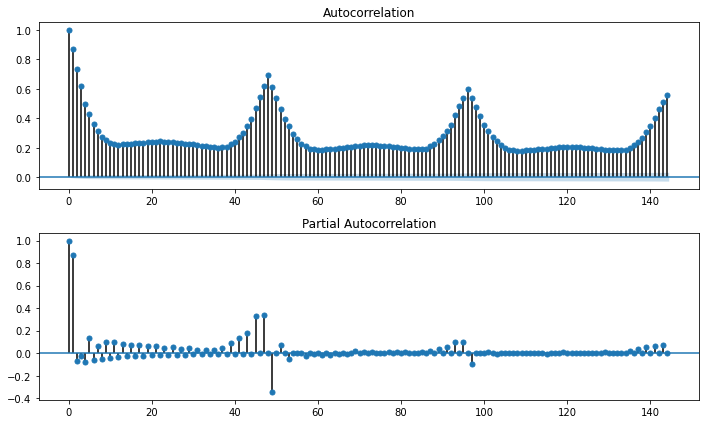

In [46]:
# Plot autocorrelation and partial autocorrelation over three days of data
lag = 3*48
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(data['price'], lags=lag, ax=ax1)
plot_pacf(data['price'], lags=lag, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the  price time series shows that the direct relationship between an observation at a given time (t) is strongest with the observations immediately preceeding it (t-1 to t-10) and with the same hour during previous days at t-48 (previous day, same hour), t-96, t-x*48 (x being the number of days). It is noteworthy that the correlation is also high in the preceedding days around the same time (see the small mounting spikes surrounding the t-x*48.



# 2. Feature Engineering

### 2.1. Correlation

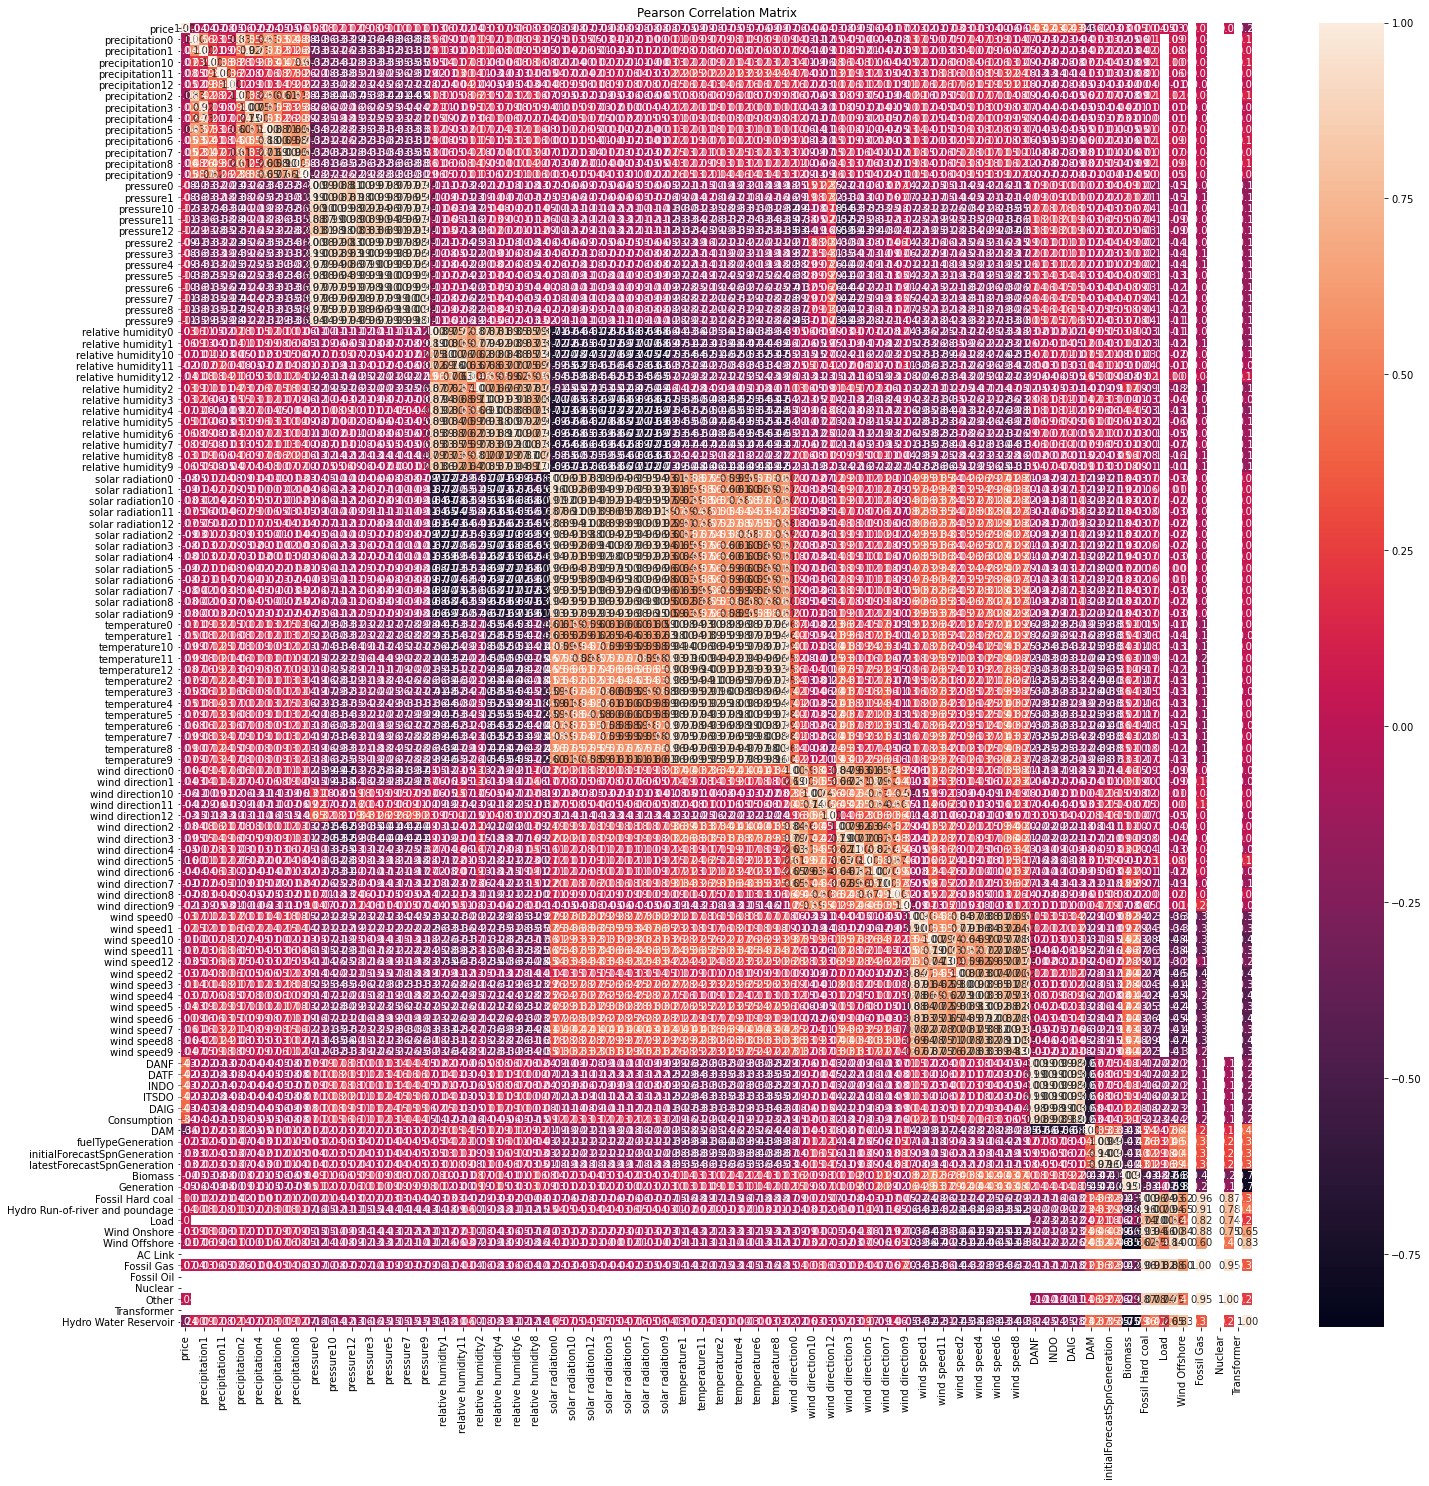

In [203]:
# Plot Pearson correlation matrix

correlations = data.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

It is hard to make much sense of the amount of information diplayed in the heatmap, though we can simply say that there are a few features strongly correlated with the first column (target variable), and many more with a weak correlation

In [47]:
# Correlations between the  price and the rest of the features

correlations = data.corr(method='pearson')
print(correlations['price'].sort_values(ascending=False).to_string())

price                              1.000000
INDO                               0.431948
DANF                               0.431283
DAIG                               0.426771
DATF                               0.422543
ITSDO                              0.422333
Consumption                        0.341655
pressure12                         0.118372
pressure10                         0.116663
pressure11                         0.111503
pressure9                          0.111329
pressure8                          0.106823
pressure7                          0.105458
pressure6                          0.103811
pressure5                          0.097661
Fossil Hard coal                   0.096269
pressure4                          0.090804
pressure2                          0.087614
pressure3                          0.084496
pressure0                          0.082109
relative humidity7                 0.080141
pressure1                          0.079107
Fossil Gas                      

From the correlation we can see many features are strongly correlated with the sport price while others are not at all. INDO, DANF, DAIG, DATF and ITSDO have a coeficient larger than 0.4, while features like relative humidity and wind direction are very close to zero

## 2.2. Generation
Let's manually handcraft specific features based on our knowledge of elements that may affect the spot price:
* working hours (9-5): during working hours, business and factories are operating, and electricity demand should be larger that in non working hours, with a postivie impact on spot price
* weekdays: expected to have a postive correlation with energy demand
* month, day of the week and hour: to account for potential seasonality and time trend: some month might have higher prices, as might specifi hours of the day or specific days of the month (i.e. payday, holiday period)


In [48]:
# Generate 'working hours' feature
for i in range(len(data)):
    position = data.index[i]
    hour = position.hour
    if (hour >= 9 and hour < 17):
        data.loc[position, 'working_hour'] = 1
    else:
        data.loc[position, 'working_hour'] = 0

In [49]:
# Generate 'weekday' feature
for i in range(len(data)):
    position = data.index[i]
    weekday = position.weekday()
    if (weekday == 6 or weekday == 5):
        data.loc[position, 'weekday'] = 0
    else:
        data.loc[position, 'weekday'] = 1

In [50]:
# Generate 'hour', 'day' and 'month' features
for i in range(len(data)):
    position = data.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    data.loc[position, 'hour'] = hour
    data.loc[position, 'day'] = weekday
    data.loc[position, 'month'] = month

## 2.4. Selection
Let's scale all features and apply Principal Component analysisi to retain the most important ones

Before continuing, recall that features are only available from 2016 onwards for the weather data.

In [51]:
# get start date of weather features
start = weather_clean.index.min()
# drop missing values
data_clean = data[start:]

In [52]:
# convert to numpy array
X = data_clean.drop('price', axis=1).values
y = data_clean['price'].values
y = y.reshape(-1, 1)

In [53]:
print(f'The data has {len(data_clean)} observations')

The data has 79102 observations


Let's roughly take 70% of the sample for training, 15% for validation and 15% for test set.

In [54]:
# define indices
train_idx = 56000
cv_idx = 68000

In [55]:
# define scaler on 0-1 scale
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [56]:
# fit scaler on the train data
scaler_X.fit(X[:train_idx])
scaler_y.fit(y[:train_idx])

MinMaxScaler()

In [57]:
# normalise dataset using the fitted scaler
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [58]:
# fit PCA
pca = PCA()
X_pca = pca.fit(X_norm[:train_idx])

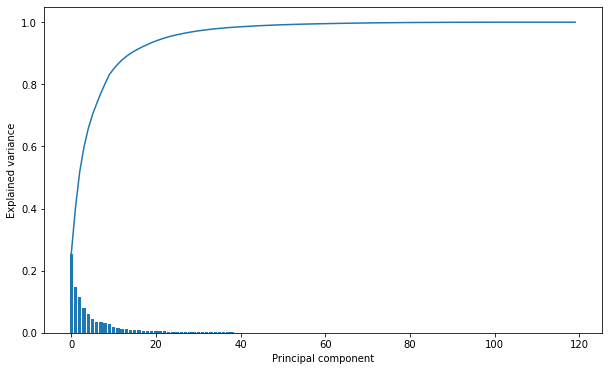

In [59]:
# plot the principal components
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()


The plot shows the cumulative explained variance ratio as a function of the number of components. This curve quantifies how much of the total, 120 dimensional variance is contained within the first N components. For example, we see that with the digits the first 20 components contain approximately 90 to 95%.

Let's set the threshold to 90% - we keep all principal components such that at least 90% of the cumulative variance is preserved.

In [60]:
# select more relevant variables
pca = PCA(n_components=0.9)
pca.fit(X_norm[:train_idx])
X_pca = pca.transform(X_norm)

In [61]:
print(f'A total of {X_pca.shape[1]} features have been retained')

A total of 16 features have been retained


# 3. Train/test/validation split

In [62]:
def shape_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [63]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 48*7 # previous week
future_target = 48 # want to predict the next day spot prices (48 timesteps ahead given 30mins frequency)

In [64]:
# train data
X_train, y_train = shape_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [65]:
# validation data
X_val, y_val= shape_data(dataset_norm, dataset_norm[:, -1],
                                     train_idx, cv_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [66]:
# test data
X_test, y_test = shape_data(dataset_norm, dataset_norm[:, -1],
                                     cv_idx, len(dataset_norm)-48, past_history, 
                                     future_target, step=1, single_step=True)

In [67]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)


# 4. Model building - XGBoost
XGBoost is an efficient implementation of gradient boosting for regression problems.

It is both fast and efficient, performing well, if not the best, on a wide range of predictive modeling tasks. Although not a time series model per se, it is very fast to compute and can be applied to a time series after transforming the time series dataset be  into a supervised learning problem first - whiich we did above.

Contrary to ARIMA models, XGBoost is agnostic about the underlying drivers of the time series, though is able to better fit the training data. Also, while LSTM and sequential neural networks may dedliver a better fit, they are very slow to train and would require more training data than the roughly 50,000 observations we have here - as the number of parameters to estimate wouldd be very large.

As an ensemble methodd, XGBoost fits a set of decision trees where new trees fix errors of those trees that are already part of the model. Trees are added until no further improvements can be made to the model.

* Target value: the 24h ahead spot power price
* Features: the prior week of half hourly data of the spot price and all 16 variables with retained with the PCA explaining 9-% of the cumulative variance

In [69]:
# reshape data to feed to X
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [70]:
# Define hyperparameters - I define here out of judgement: the learning 
# rate, the maximum tree depth, regularization, mimimun child weights 
# and subsample size. Iedally we'd perform multiple training over a 
# hyperparameter grid
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test) 
eval_list = [(dtrain, 'train'), (dval, 'eval')]

# train XGBoost
xgb_model = xgb.train(param, dtrain, 150, eval_list, early_stopping_rounds=3)

[23:58:56] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.43961	eval-rmse:0.44939
[1]	train-rmse:0.42643	eval-rmse:0.43600
[2]	train-rmse:0.41364	eval-rmse:0.42300
[3]	train-rmse:0.40124	eval-rmse:0.41037
[4]	train-rmse:0.38921	eval-rmse:0.39814
[5]	train-rmse:0.37755	eval-rmse:0.38627
[6]	train-rmse:0.36623	eval-rmse:0.37476
[7]	train-rmse:0.35525	eval-rmse:0.36359
[8]	train-rmse:0.34460	eval-rmse:0.35275
[9]	train-rmse:0.33427	eval-rmse:0.34224
[10]	train-rmse:0.32425	eval-rmse:0.33205
[11]	train-rmse:0.31454	eval-rmse:0.32215
[

In [71]:
# save model
xgb_model.save_model('xgb_spot_price_150.model')


In [76]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE (on re-scaled data) of 1 day ahead spot price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE (on re-scaled data) of 1 day ahead spot price XGBoost forecast: 14.439


In [77]:
# create df for displaying the results with actual values
pred_comp = data_clean.iloc[cv_idx+48*8:]
pred_comp = pd.DataFrame(pred_comp['price'])
pred_comp['pred'] = xgb_forecast_inv

In [78]:
pred_comp.head()

price       pred
2020-02-20 17:00:00+00:00   40.4  47.353905
2020-02-20 17:30:00+00:00   40.4  47.779533
2020-02-20 18:00:00+00:00   46.5  49.984119
2020-02-20 18:30:00+00:00   46.5  50.642128
2020-02-20 19:00:00+00:00   40.6  47.157299

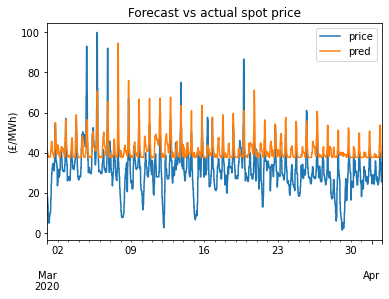

In [79]:
# show a sample month of results
pred_comp['2020-03-01':'2020-04-01'][["price", "pred"]].plot()

plt.title("Forecast vs actual spot price")
plt.ylabel("(£/MWh)")
plt.legend()
plt.show()

We can see that the model returns relatively good predictions of the spot price!

# 5. Discussion
## Performance assessment
The RMSE achieved on the test set is still relatively high at 14, where the average spot price oscilates around 45. As we can tell form training RMSE (though using the normalised values), it is steadily decreasing every training passes. Training it for longer would improve the fit substantially.

From the graph above, we see that the main issue is with the 'average' but that actually the variations - both postive and negative spikes have bee learnt very well!

## Improve performance
I have so far simply decided on the hyperparameters out of judgement (depth, features, learnig rate, regularization...). To improve the fit:
* train longer
* make learning rate adaptable
* hyperparameter tuning: grid search over model hyper parameters to select best architecture
* watch out for overfitting - could revise the feature selection threshold (from 70% to 95% of the cumulative variance)

In any case, to improve performance trainingmore than one mode is needed playing with its hyper-parameters so that cross comparisons can drive a proper model selection

## Productionise model
Once the model has been refined, we can productionise it. This requires automate the data pipeline to gather the sample on which to make the predictions, automate the model run and save the outputs before 7 BST every day.

#### Data pipeline
Every day, at 6:30 BST all half hourly data of the previous 8 days needs to be shaped to be fed to the trained model. This needs to prepare 48 datapoints of features - so the next 24h Spot price can be predicted half-hourly.
* collection
* shaping
* formating / normalisation

#### Model run
Save the trained model parameters and run the output of the data pipeline every day at 6.30 once the data process has finished. 

#### Save 
The model runs will deliver a file with 48 data points, one for each spot price half hourly until 6.30 am the next day.

#### Infrastructure
Using AWS and terraform setting the infrastructures and task is simple. The infrastructures required are:
* database storing the features updated every day at 6.30
* instance EC2
* bucket S3

We should write a brief bash file to create a container that access the data base and implements the pipeline. Then the same executable calls the model and runs the new data through it, exporting the outoputs to the S3 wehre it can be accessed by the end user. The containter image can then be programmed using a recurrent task to start every day at 6.30.